In [1]:
#from spatial_metabolic_distribution import Maps, MetabolicPropertyMapsAssembler
from spectral_spatial_simulation import Model as SpectralSpatialModel
from spectral_spatial_simulation import FID
from sampling import Model as SamplingModel
from matplotlib.pyplot import legend, title
import matplotlib.pyplot as plt
from display import plot_FID
from easygraph import Graph
#from printer import Console
from prettyconsole import Console
import dask.array as da
import numpy as np
import cupy as cp
import os.path
import tools
import dask
import pint
import file
import h5py
import sys

from tqdm import tqdm
import warnings

# Both required for the JupyterPlotManager
from tools import JupyterPlotManager
%matplotlib ipympl

# For e.g., storing to disk (dask.to_zarr)
from tools import DaskTools

# For some incomplete data
from spatial_metabolic_distribution import ParameterMap, ParameterVolume

In [2]:
# Only for testing purposes: To make only certain number of GPUs to whole code visible. Note changed indices!
#import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "1,2,3"

In [3]:
# Initialise the UnitRegistry
u = pint.UnitRegistry()

# Check number of reserved CPUs and total available CPUs

In [4]:
print("available number of CPUs for this simulation (vary if reserved):")
!nproc

available number of CPUs for this simulation (vary if reserved):
40


In [5]:
print("all logical CPUs on the system:")
!nproc --all

all logical CPUs on the system:
40


# Check current GPU load & Define GPU(s) for small and big tasks

In [6]:
# Set generally visible GPU devices

!nvidia-smi

Mon Feb 23 22:48:29 2026       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.274.02             Driver Version: 535.274.02   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-DGXS-32GB           On  | 00000000:07:00.0 Off |                    0 |
| N/A   33C    P0              52W / 300W |  30059MiB / 32768MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [7]:
#import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "1,2,3"


target_gpu_smaller_tasks = 2
target_gpus_big_tasks = [2,3]

device_memory_limit = "32GB"

# Check free RAM

In [8]:
!free -h

               total        used        free      shared  buff/cache   available
Mem:           251Gi        33Gi        93Gi       4.1Gi       124Gi       212Gi
Swap:             0B          0B          0B


# <span style="color:red">Define Simulation paramaters (TODO collect all important ones). Are they already base units?!</span>

In [9]:
TE=0.0013*u.s  # secound
TR=0.6*u.s     # secound
alpha=45*u.deg # degree
larmor_frequency = 297223042 * u.Hz # Hz

target_resolution_xyz = (112, 128, 80)
target_resolution_fid = 1536

# Define block size for Dask

In [10]:
#block_size_spectral_spatial_model = (90, 112, 128, 80)
block_size_spectral_spatial_model = (40, 112, 128, 80)
#block_size_sampling_model = (4, 90, 112, 128, 80) # test with bigger chunksize
block_size_sampling_model = (5, 40, 112, 128, 80) # test with bigger chunksize

# Load defined paths in the configurator

In [11]:
config_file_name = "paths_09012026.json"

In [12]:
configurator = file.Configurator(path_folder="../config/",
                                 file_name=config_file_name)
configurator.load()

# Load metabolic mask

In [13]:
metabolic_mask = file.Mask(configurator=configurator)
metabolic_mask.load(mask_name="metabolites", data_type=np.float32)
metabolic_mask.mask.data = tools.InterpolationTools().interpolate(array=metabolic_mask.mask.data, target_size=target_resolution_xyz, order=3, compute_on_device="gpu", return_on_device="cpu", target_gpu=target_gpu_smaller_tasks)

[  1  ][ success ] ---v                       
                      Loaded file 'Vol_004_mask_slab.nii':
                          Shape             -> (112, 128, 80)
                          Pixel dimensions: -> (1.7188, 1.7188, 1.72)
                          Values range:     -> [0.0, 1.0]
                          Data type:        -> <class 'numpy.float32'>
                          In memory cache?  -> True
[  2  ][ success ] >> Thus, loaded the 'metabolites' mask.                                                                 
[  3  ][  info   ] >> Interpolate on GPU: 2                                                                                
[  4  ][ success ] ---v                       
                      Interpolated on gpu and returned on cpu 
                      Shape (112, 128, 80) (4.375 mebibyte) => (112, 128, 80) (4.375 mebibyte)


In [14]:
type(metabolic_mask.mask.data)

numpy.ndarray

In [15]:
# (!!!!!!!!) TODO: Add interpolation option to MASK!!!!!
# (!!!!!!!!) TODO: Add interpolation option to MASK!!!!!
# (!!!!!!!!) TODO: Add interpolation option to MASK!!!!!
# (!!!!!!!!) TODO: Add interpolation option to MASK!!!!!
# (!!!!!!!!) TODO: Add interpolation option to MASK!!!!!
# (!!!!!!!!) TODO: Add interpolation option to MASK!!!!!
# (!!!!!!!!) TODO: Add interpolation option to MASK!!!!!
# (!!!!!!!!) TODO: Add interpolation option to MASK!!!!!
# (!!!!!!!!) TODO: Add interpolation option to MASK!!!!!
# (!!!!!!!!) TODO: Add interpolation option to MASK!!!!!
# (!!!!!!!!) TODO: Add interpolation option to MASK!!!!!
# (!!!!!!!!) TODO: Add interpolation option to MASK!!!!!

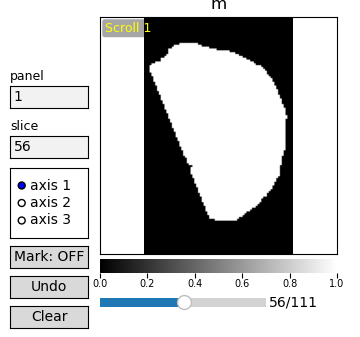

In [16]:
metabolic_mask.plot_jupyter()

# Load the FIDs

In [17]:
metabolites = file.FID(configurator=configurator)
metabolites.load(fid_name="metabolites", signal_data_type=np.complex64) # TODO TODO, here seems to be an issue => data type has no effect?
metabolites.loaded_fid.change_signal_data_type("complex64")
metabolites.loaded_fid.change_time_data_type("float32")

[  5  ][  info   ] ---v                       
                      Loaded FID signal as <class 'numpy.complex64'> 
                       -> thus using space: 264.0 KB 
                       -> thus using digits: 15
[  6  ][ success ] >> Transformed FID signal to complex values: (16896, 2) -> (16896,)                                     
[  7  ][ success ] ---v  (collected several lines)                      
                      Assigned FID parts:
                      0. Acetyl+Aspartyl_moi(NAAG) -----> shape: (1536,)
                      1. Choline_moi(GPC) --------------> shape: (1536,)
                      2. Creatine (Cr) -----------------> shape: (1536,)
                      3. Glutamate (Glu) ---------------> shape: (1536,)
                      4. Glutamate_moi(NAAG) -----------> shape: (1536,)
                      5. Glutamine_noNH2 (Gln) ---------> shape: (1536,)
                      6. Glycerol_moi(GPC) -------------> shape: (1536,)
                      7. MyoIno

[ 11  ][ warning ] >> No reference frequency is specified. Choosing: 297223042 Hz.                                         
[ 12  ][ warning ] >> No ppm center is specified. Choosing: 4.7 ppm.                                                       


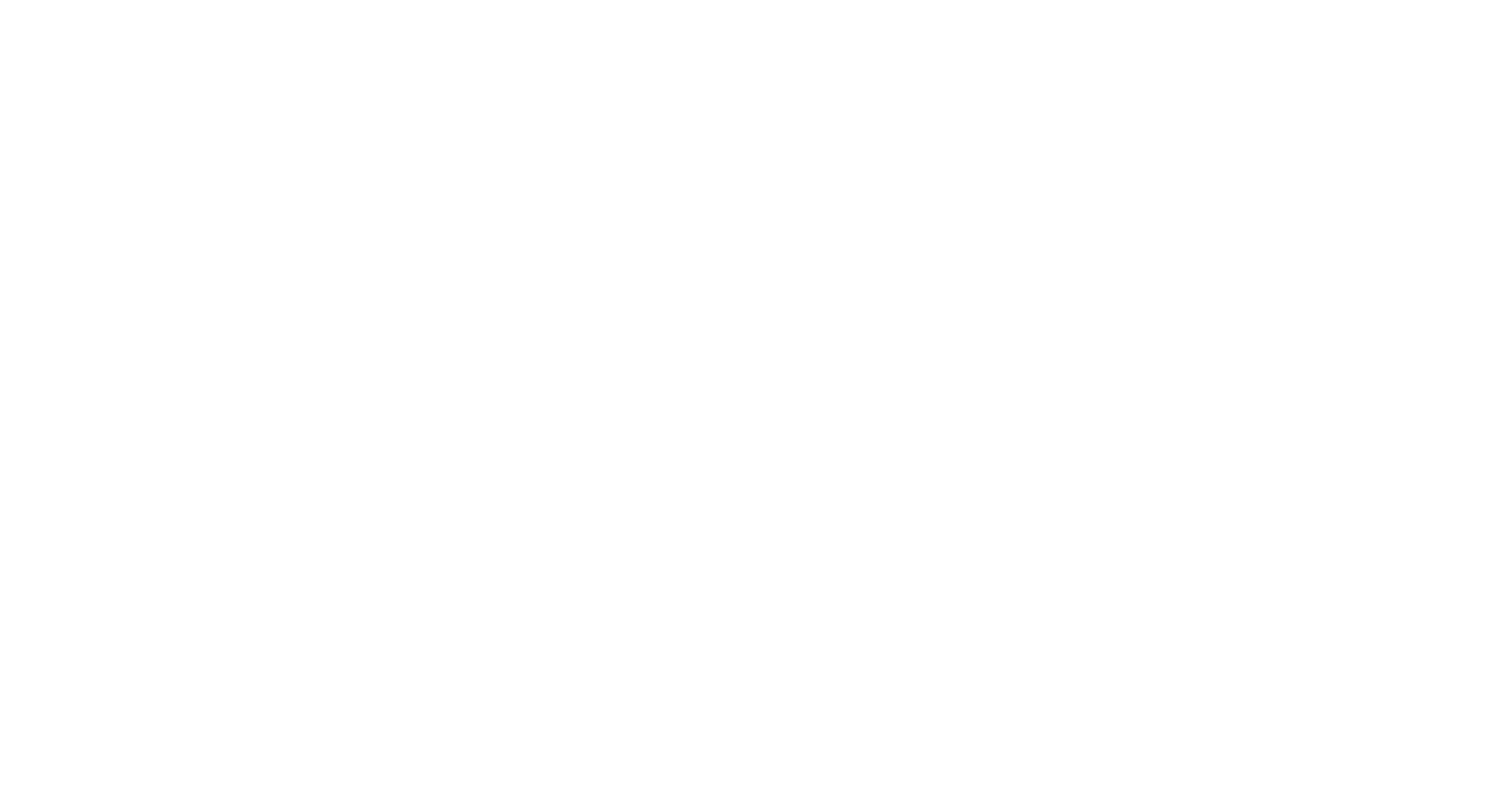

In [18]:
loaded_fid = metabolites.loaded_fid
#loaded_fid.plot(x_type="time", plot_offset=10)
loaded_fid.plot()

#### <span style="color:red">!!! Interpolate to 100.000 FID points for test purposes OR to desired resolution.</span>

In [19]:
loaded_fid.interpolate(timepoints=target_resolution_fid)

[ 13  ][ success ] ---v                       
                      Interpolated FID: 
                       => time shape:   (1536,)         --> (1536,) 
                       => signal shape: (11, 1536)      --> (11, 1536)


# Load and prepare the concentration maps

#### Load the desired concentration maps

In [20]:
loaded_concentration_maps = file.ParameterMaps(configurator=configurator, map_type_name="metabolites_concentration")
working_name_and_file_name = {"Glu": "MetMap_Glu_con_map_TargetRes_HiRes.nii",
                              "Gln": "MetMap_Gln_con_map_TargetRes_HiRes.nii",
                              "m-Ins": "MetMap_Ins_con_map_TargetRes_HiRes.nii",
                              "NAA": "MetMap_NAA_con_map_TargetRes_HiRes.nii",
                              "Cr+PCr": "MetMap_Cr+PCr_con_map_TargetRes_HiRes.nii",
                              "GPC+PCh": "MetMap_GPC+PCh_con_map_TargetRes_HiRes.nii",
                             }
loaded_concentration_maps.load_files_from_folder(working_name_and_file_name=working_name_and_file_name)

[ 14  ][  info   ] >> Maps object: The provided path points to a folder                                                    
[ 15  ][ warning ] >> Maps.load_files_from_folder ==> by standard nii is loaded. No h5 support yet!                        
[ 16  ][ warning ] >> The same unit is assumed for all the files in the given folder!                                      
[ 17  ][ success ] ---v  (collected several lines)                      
                      Loaded maps: 
                        0: working name: .......Glu | Shape:   (440, 440, 266) | Values range: [0.0, 42.733] | Unit: millimole |
                        1: working name: .......Gln | Shape:   (440, 440, 266) | Values range: [0.0, 41.138] | Unit: millimole |
                        2: working name: .....m-Ins | Shape:   (440, 440, 266) | Values range: [0.0, 40.316] | Unit: millimole |
                        3: working name: .......NAA | Shape:   (440, 440, 266) | Values range: [0.0, 42.934] | Unit: millimole |
   

#### Convert to base units and display loaded data

[ 18  ][ success ] >> Converted to base units: millimole -> mole                                                           


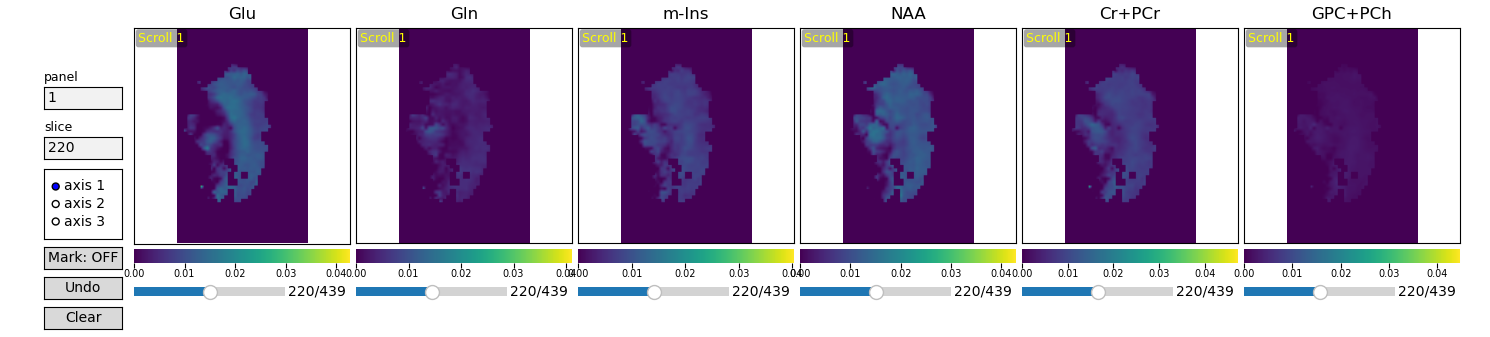

In [21]:
# Convert to base units (e.g., mmol to mol)
loaded_concentration_maps.to_base_units()
# Display the data
import time
time.sleep(1)
loaded_concentration_maps.plot_jupyter(cmap="viridis")

#### Create 4D array from the 3D arrays and interpolate to target shape

In [22]:
# Convert the file.Maps object to a ParamaterVolume of shape (metabolite, X, Y, Z) & change to float32
concentration_volume = loaded_concentration_maps.to_working_volume(data_type="float32")

# Interpolate to the shape of the 
concentration_volume.interpolate(target_size=metabolic_mask.mask.shape, order=3, device="gpu", target_gpu=target_gpu_smaller_tasks, verbose=False)

[ 19  ][ success ] ---v                       
                      Created 4D volume of metabolite maps: ['Glu', 'Gln', 'm-Ins', 'NAA', 'Cr+PCr', 'GPC+PCh']. 
                       Map type: ....... metabolites_concentration 
                       Unit: ........... mole 
                       Shape: .......... (6, 440, 440, 266) 
                       Data type: ...... float64 
                       Space: .......... 2357.4 mebibyte
[ 20  ][ success ] >> Changed the data type from float64 (2357.4 mebibyte) -> float32 (1178.7 mebibyte)                    
[ 21  ][  info   ] >> Interpolate on GPU: 2                                                                                


# Load and prepare the T1 maps
### <span style="color:red">!!! Only one T1 map is loaded at the moment and used for each metabolite.</span>

#### <span style="color:red">!!! Load only one t1 maps and then convert to base units.</span>

In [23]:
loaded_t1_map = file.ParameterMaps(configurator=configurator, map_type_name="T1")
loaded_t1_map.load_file()
loaded_t1_map.to_base_units()

[ 22  ][  info   ] >> Maps object: The provided path points to a file                                                      
[ 23  ][  info   ] >> Loading nii file for map type T1                                                                     
[ 24  ][ success ] ---v  (collected several lines)                      
                      Loaded nii map: T1_TargetRes_HiRes.nii | Shape: (440, 440, 266) | Values range: [-327.493, 4848.004] | Unit: millisecond | Unique values: 888245
                      
[ 25  ][ success ] >> Converted to base units: millisecond -> second                                                       


#### <span style="color:red">!!! Assemble pseudo 4D array of T1 maps (same for each metabolite).</span>

In [24]:
t1_volume = ParameterVolume(maps_type="T1")

for metabolite in concentration_volume.metabolites:
    parameter_map = ParameterMap(map_type=loaded_t1_map.map_type_name, metabolite_name=metabolite, values=loaded_t1_map.loaded_maps, unit=loaded_t1_map.loaded_maps_unit)
    t1_volume.add_map(parameter_map)

t1_volume.to_volume()
t1_volume.interpolate(target_size=metabolic_mask.mask.shape, order=3, device="gpu", target_gpu=target_gpu_smaller_tasks, verbose=False)
t1_volume.to_data_type("float32")

[ 26  ][ success ] ---v                       
                      Created 4D volume of metabolite maps: ['Glu', 'Gln', 'm-Ins', 'NAA', 'Cr+PCr', 'GPC+PCh']. 
                       Map type: ....... T1 
                       Unit: ........... second 
                       Shape: .......... (6, 440, 440, 266) 
                       Data type: ...... float64 
                       Space: .......... 2357.4 mebibyte
[ 27  ][  info   ] >> Interpolate on GPU: 2                                                                                
[ 28  ][ success ] >> Changed the data type from float64 (52.5 mebibyte) -> float32 (26.25 mebibyte)                       


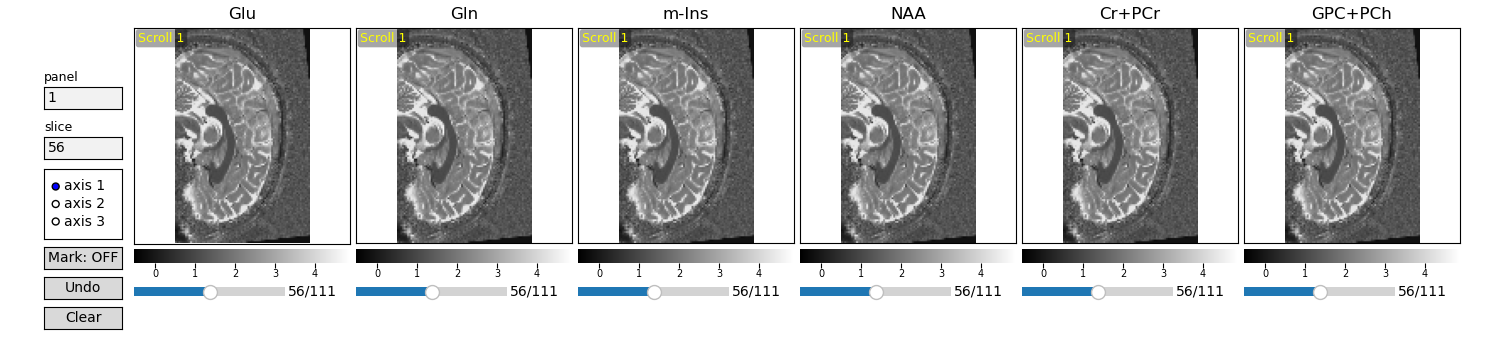

In [25]:
import time
time.sleep(1)
t1_volume.display_jupyter(display="volume")

# Load and prepare the T2 maps

#### <span style="color:red">!!! The reference where T2 vales ares used from. Only homogenious at the moment.</span>

In [26]:
# Using T2 values from:
cm = tools.CitationManager("../docs/references.bib")
cm.cite("versteeg2024high")
# But also see:
cm.cite("seginer2022phase")

t2_WM = (25+39)/2*u.ms
t2_GM = (33+55)/2*u.ms

t2_GM_WM_average = (t2_WM+t2_GM)/2
t2_GM_WM_average = t2_GM_WM_average.to_base_units()

t2_GM_WM_average
# Do I have GM and WM segmentation?

Entry type online not standard. Not considered.


<Quantity(0.038, 'second')>

In [27]:
t2_volume = ParameterVolume(maps_type="T2")

for metabolite in concentration_volume.metabolites:
    parameter_map = ParameterMap(map_type="T2", metabolite_name=metabolite, values=np.full(metabolic_mask.mask.shape, t2_GM_WM_average), unit=t2_GM_WM_average.units)
    t2_volume.add_map(parameter_map)

t2_volume.to_volume()
t2_volume.to_data_type("float32")
#t2_volume.interpolate_volume(target_size=metabolic_mask.mask.shape, order=3, device="gpu", target_gpu=target_gpu_smaller_tasks, verbose=False)

[ 29  ][ success ] ---v                       
                      Created 4D volume of metabolite maps: ['Glu', 'Gln', 'm-Ins', 'NAA', 'Cr+PCr', 'GPC+PCh']. 
                       Map type: ....... T2 
                       Unit: ........... second 
                       Shape: .......... (6, 112, 128, 80) 
                       Data type: ...... float64 
                       Space: .......... 52.5 mebibyte
[ 30  ][ success ] >> Changed the data type from float64 (52.5 mebibyte) -> float32 (26.25 mebibyte)                       


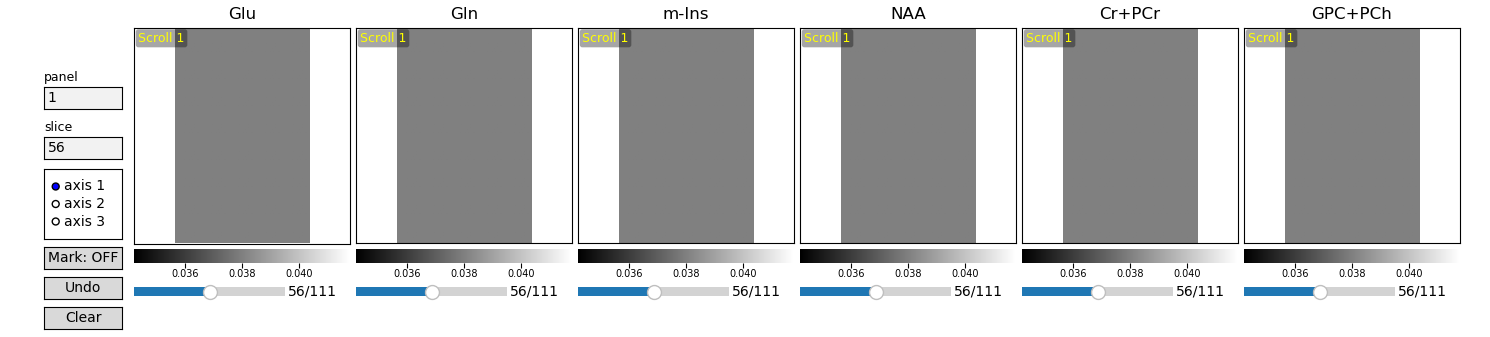

In [28]:
import time
time.sleep(2)
t2_volume.display_jupyter()

# Use desired FID signals and merge some of them

In [29]:
using_fid_signals = ["Glutamate (Glu)",
                     "Glutamine_noNH2 (Gln)",
                     "MyoInositol (m-Ins)",
                     "NAcetylAspartate (NAA)",
                     "Creatine (Cr)",
                     "Phosphocreatine (PCr)",
                     "Choline_moi(GPC)",
                     "Glycerol_moi(GPC)",
                     "PhosphorylCholine_new1 (PC)"]

In [30]:
# Take a subset of all signals of the FID. This returns a new FID object.
fid = loaded_fid.get_partly_fid(using_fid_signals)

# Merge signals of the FID in order to match the Maps
fid.merge_signals(names=["Creatine (Cr)", "Phosphocreatine (PCr)"],
                  new_name="Cr+PCr",
                  divisor=2)

fid.merge_signals(names=["Choline_moi(GPC)", "Glycerol_moi(GPC)", "PhosphorylCholine_new1 (PC)"],
                  new_name="GPC+PCh",
                  divisor=2)

fid.name = fid.get_name_abbreviation()

[ 31  ][ success ] ---v  (automatic line breaks) 
                      Merged signals of ['Creatine (Cr)', 'Phosphocreatine (PCr)'] with factor 1/2. New name of signal:
                      Cr+PCr
[ 32  ][ success ] ---v  (automatic line breaks) 
                      Merged signals of ['Choline_moi(GPC)', 'Glycerol_moi(GPC)', 'PhosphorylCholine_new1 (PC)'] with
                      factor 1/2. New name of signal: GPC+PCh


# Create Spectral-Spatial Model (Spectral-spatial combination)

Inclusion of the steady state, which is achieved through repeated excitation and is determined by the T1 decay. If T1 < TR, then no full longitudional recovery possible and thus not Mz ≠ M0. Here the T2 instead of the T2* is used, since later the B0 effect are included. The bigger the T2 the slower the transversal (measurable) signal decays.

Steady state due to T1:
$S_{\text{out}} = S_{\text{in}} \, \sin(\alpha)\, \frac{1 - e^{-TR/T_1}}{1 - \cos(\alpha)\, e^{-TR/T_1}}$

T2 decay:
$S_{\text{out}} = S_{\text{in}} \, e^{-\frac{TE + t}{T_2}}$

**To discover the effect of the individual parameters check the following link: https://steady-state-and-t2-star.streamlit.app/ (Note, here T2\* instead of T2 is shown)**


#### Ensure that each map has the same order

In [31]:
# (1) Ensure that the metabolite order is the same for all volumes
desired_order = ['Glu', 'Gln', 'm-Ins', 'NAA', 'Cr+PCr', 'GPC+PCh']
concentration_volume.reorder_metabolites(desired_order)
t1_volume.reorder_metabolites(desired_order)
t2_volume.reorder_metabolites(desired_order)

[ 33  ][ warning ] >> No sorting is applied since already desired order is given!                                          
[ 34  ][ warning ] >> No sorting is applied since already desired order is given!                                          
[ 35  ][ warning ] >> No sorting is applied since already desired order is given!                                          


#### Create the model

In [32]:
spectral_spatial_model = SpectralSpatialModel(path_cache=configurator.data["cache"],
                                              block_size=block_size_spectral_spatial_model,
                                              TE=TE,
                                              TR=TR,
                                              alpha=alpha,
                                              data_type="complex64",
                                              compute_on_device="gpu",
                                              return_on_device="gpu")


# Add all the parameter maps (spatial)
spectral_spatial_model.add_parameter_volume("T1", t1_volume)
spectral_spatial_model.add_parameter_volume("T2", t2_volume)
spectral_spatial_model.add_parameter_volume("concentration", concentration_volume)
spectral_spatial_model.add_mask(metabolic_mask.mask.data)                       # Mask of brain

# Add the FID signals (spectral)
#fid.time = fid.time * u.s # to add seconds # TODO
spectral_spatial_model.add_fid(fid)                                             # Add FID (all separate signals summed up)

spectral_spatial_model.model_summary()

[ 36  ][ warning ] >> The T1 volume exhibits zero and/or negative values: -0.5247434973716736                              
[ 37  ][ success ] >> Converted negative and zero values to eps: 1.1920928955078125e-07                                    
[ 38  ][ success ] >> Added T1 to the Spectral Spatial Model.                                                              
[ 39  ][ success ] >> Added T2 to the Spectral Spatial Model.                                                              
[ 40  ][ warning ] >> The concentration volume exhibits negative values: -0.004001666326075792                             
[ 41  ][ success ] >> Converted negative values to eps: 1.1920928955078125e-07                                             
[ 42  ][ success ] >> Added concentration to the Spectral Spatial Model.                                                   
[ 43  ][ success ] >> Added mask to the spectral spatial model.                                                            
[ 44  ][

In [33]:
computational_graph_0 = spectral_spatial_model.assemble_graph()
computational_graph_0

[ 46  ][  info   ] >> Start to assemble whole graph on device gpu                                                          


dask.array<sum-aggregate, shape=(1536, 112, 128, 80), dtype=complex64, chunksize=(40, 112, 128, 80), chunktype=cupy.ndarray>

# TODO: Add here B0 map

$S_{out}(t)=S_{in}(t)\,e^{i\,2\pi\,\Delta f\,t}$     $~~~~~~~$or$~~~~~~~$   $S_{out}(t)=S_{in}(t)\,e^{i\,\Delta \omega\,t}$ (if already rad/s)

[ 47  ][  info   ] >> Maps object: The provided path points to a file                                                      
[ 48  ][  info   ] >> Loading nii file for map type B0                                                                     
[ 49  ][ success ] ---v  (collected several lines)                      
                      Loaded nii map: B0Map_TargetRes.nii | Shape: (180, 180, 109) | Values range: [-533.767, 1068.09] | Unit: hertz | Unique values: 1471604
                      
[ 50  ][ success ] >> Converted to base units: hertz -> 1 / second                                                         


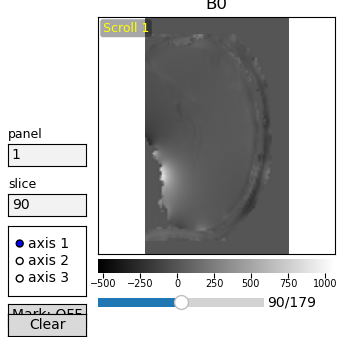

In [34]:
# Load B0 Map
loaded_B0_map = file.ParameterMaps(configurator=configurator, map_type_name="B0")
loaded_B0_map.load_file()
loaded_B0_map.to_base_units()
loaded_B0_map.plot_jupyter(cmap="gray")

In [35]:
# Interpolate B0 map to target size
from spatial_metabolic_distribution import ParameterMap
working_B0_map = ParameterMap(map_type="B0", metabolite_name=None, values=loaded_B0_map.loaded_maps["B0"], unit=loaded_B0_map.loaded_maps_unit)
working_B0_map.interpolate(target_size=metabolic_mask.mask.shape, order=3, device="gpu", target_gpu=target_gpu_smaller_tasks, verbose=True)
# Transform to dask array, choose right chunksize
B0_map_dask = da.asarray(working_B0_map.values, chunks=block_size_spectral_spatial_model[1:])
B0_map_dask

[ 51  ][  info   ] >> Interpolate on GPU: 2                                                                                
[ 52  ][ success ] ---v                       
                      Interpolated on gpu and returned on cpu 
                      Shape (180, 180, 109) (26.9439697265625 mebibyte) => (112, 128, 80) (8.75 mebibyte)


dask.array<array, shape=(112, 128, 80), dtype=float64, chunksize=(112, 128, 80), chunktype=numpy.ndarray>

In [36]:
# Apply equation
from tools import GPUTools
fid_time = da.asarray(fid.time, chunks=(block_size_spectral_spatial_model[0]))
fid_time_gpu = GPUTools.dask_map_blocks(fid_time, device="gpu")
B0_map_dask_gpu = GPUTools.dask_map_blocks(B0_map_dask, device="gpu")

#phase = da.exp(1j *  fid_time_gpu[:, None, None, None] * B0_map_dask_gpu[None, :, :, :], dtype="complex64")
phase = da.exp(1j * 2 * cp.pi * fid_time_gpu[:, None, None, None] * B0_map_dask_gpu[None, :, :, :], dtype="complex64")

computational_graph_0 = computational_graph_0 * phase

# Sampling model

### Load the coil sensitivity maps

In [37]:
coil_sensitivity_maps_loader = file.CoilSensitivityMaps(configurator=configurator)
coil_sensitivity_maps_loader.load_h5py(keys=["imag", "real"], dtype=np.complex64)

[ 53  ][ success ] ---v  (collected several lines)                      
                      Coil Sensitivity Maps:
                       => Could find keys ['imag', 'real'] in the HDF5 file
                       => Loaded and converted maps to complex64
                       => Data shape: (32, 80, 86, 86)
                       => Space required: 144.45 mebibyte
                      


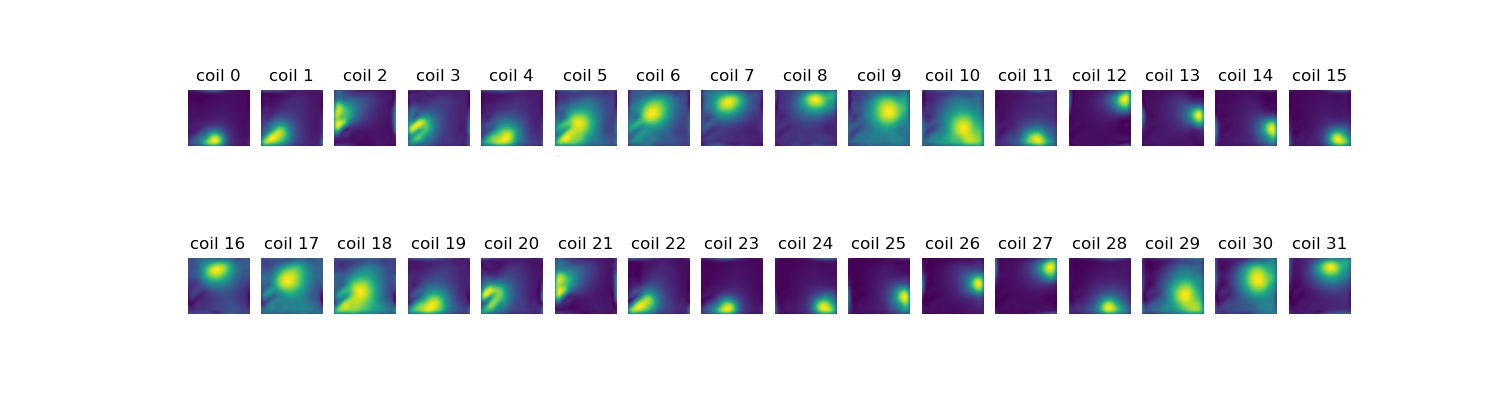

In [38]:
#coil_sensitivity_maps_loader.plot_jupyter(cmap="viridis")
coil_sensitivity_maps_loader.plot(cmap="viridis")

### Convert to working volume and interpolate

In [39]:
coil_sensitivity_volume = coil_sensitivity_maps_loader.to_working_volume()
coil_sensitivity_volume.interpolate(target_size=metabolic_mask.mask.shape, target_gpu=target_gpu_smaller_tasks)

[ 54  ][ success ] >> Transformed file.CoilSensitivityMaps => sampling.CoilSensitivityVolume                               
[ 55  ][  info   ] >> Preserving coil dimension during interpolation.                                                      
[ 56  ][  info   ] >> Interpolate on GPU: 2                                                                                
[ 57  ][ success ] ---v                       
                      Interpolated on gpu and returned on cpu 
                      Shape (32, 80, 86, 86) (144.453125 mebibyte) => (32, 112, 128, 80) (280.0 mebibyte)


In [40]:
coil_sensitivity_volume

### Create the sampling model & Apply the coil sensitivity maps

In [41]:
sampling_model = SamplingModel(block_size=block_size_sampling_model,
                               path_cache=configurator.data["cache"],
                               data_type="complex64",
                               coil_sensitivity_volume=coil_sensitivity_volume,
                               spectral_spatial_volume=computational_graph_0, 
                               target_gpu_smaller_tasks=target_gpu_smaller_tasks)

# TODO: Implement to print summary!!!! sampling_model.summary()

[ 58  ][  info   ] >> Please note that the 'working_volume' of the Sampling Model will be updated with each operation!
    
[ 59  ][  info   ] ---v  (collected several lines)                      
                      No slice to plot is specified. Choosing: 43
                      Sampling Model:
                       => Got spectral spatial volume:
                          class type: .......... <class 'dask.array.core.Array'>
                          data type: ........... complex64
                          shape: ............... (1536, 112, 128, 80)
                      
                       => Got coil sensitivity volume:
                          class type: .......... <class 'sampling.CoilSensitivityVolume'>
                          volume data type: .... complex64
                          volume shape: ........ (32, 112, 128, 80)
                      
                       => Desired overall block size for dask: ... (5, 40, 112, 128, 80)
                       => C

In [42]:
sampling_model.apply_coil_sensitivity(compute_on_device="gpu", return_on_device="gpu") # note that model.working_volume is affected!

[ 60  ][ success ] >> Added to apply coil sensitivity maps computational graph.                                            


dask.array<mul, shape=(32, 1536, 112, 128, 80), dtype=complex64, chunksize=(5, 40, 112, 128, 80), chunktype=cupy.ndarray>

#### <span style="color:red">!!! Add noise (TODO: scale) & Noise Correlation Matrix.</span>


$M_{noisecorr} \cdot \biggl(\frac{n}{trace(M_{noisecorr})}\biggr)$

$A_{ij} = \overline{A_{ji}}$

$
A=
\begin{pmatrix}
2 & 1+3i \\
1-3i & 5
\end{pmatrix}
$

In [43]:
#sampling_model.working_volume.shape
#tools.SpaceEstimator.for_array((32,1536,112,128,80), data_type="complex64", unit="GiB")

##shape = sampling_model.working_volume.shape
##chunks = block_size_sampling_model

# Dask uses cupy as backend
##with dask.config.set({"array.backend": "cupy"}):
##    rng = da.random.default_rng(0)

##    noise = (rng.standard_normal(shape, chunks=chunks).astype(cp.float32) + 1j * rng.standard_normal(shape, chunks=chunks).astype(cp.float32)) / cp.float32(np.sqrt(2.0))
##    noise = noise.astype(cp.complex64)

##noise

In [44]:
# DELETE DELETE DELETE

## Bring to k-space (FFT + FFT shift)

In [45]:
sampling_model.apply_cartesian_FT(direction="forward", fft_shift=True, compute_on_device="gpu", return_on_device="gpu")

[ 61  ][ success ] ---v  (collected several lines)                      
                      Adding Fourier Transformation to Dask Graph:
                       => Direction:............... forward
                       => Applying (i)FFT-shift:... True
                       => Affected axes:........... (2, 3, 4) of 5 total axes
                       => Rechunking:.............. (5, 40, 112, 128, 80) => (5, 40, 112, 128, 80)
                       => Data type:............... complex64 => complex64
                       => Performing on device:.... gpu
                      


dask.array<fftshift, shape=(32, 1536, 112, 128, 80), dtype=complex64, chunksize=(5, 40, 112, 128, 80), chunktype=cupy.ndarray>

## Crop k-space center to (64,64,40)

In [46]:
crop_k_space_center = (64,64,40)
sampling_model.crop_k_space_center(crop_center_shape=crop_k_space_center)

[ 62  ][ success ] >> Cropping k-space center (..., X,Y,Z) from (32, 1536, 112, 128, 80) => (32, 1536, 64, 64, 40)         


dask.array<getitem, shape=(32, 1536, 64, 64, 40), dtype=complex64, chunksize=(5, 40, 64, 64, 40), chunktype=cupy.ndarray>

# TODO: Add gaussian NOISE. Certain SNR

In [47]:
sampling_model.working_volume.chunksize
#block_size_sampling_model

(5, 40, 64, 64, 40)

In [48]:
# -1) Define noise scaling factor
noise_scaling_factor = 0.1

# 0) Get current Model's shape (should be cropped one!)
shape = sampling_model.working_volume.shape

# 1) Generate uncorrelated Gaussian noise
with dask.config.set({"array.backend": "numpy"}):
    rng = da.random.default_rng(0)
    noise = (rng.standard_normal(shape, chunks=sampling_model.working_volume.chunksize).astype(cp.float32) + 1j * rng.standard_normal(shape, chunks=sampling_model.working_volume.chunksize).astype(cp.float32)) / cp.float32(np.sqrt(2.0))
    noise = noise.astype(cp.complex64)

noise_gpu = tools.GPUTools.dask_map_blocks(noise, device="gpu")

# 2) Noise Correlation
#    a) Load the map
noise_correlation_path = configurator.data["maps"]["noise_correlation"]["path"]
with h5py.File(noise_correlation_path, "r") as f:
    #print(list(f.keys()))          
    noise_correlation = np.asarray(f["NoiseCorrMatStruct"]["Data"])
    noise_correlation_complex = noise_correlation["real"] + 1j * noise_correlation["imag"]
    # numpy -> cupy
noise_correlation_complex_gpu = tools.GPUTools.to_cupy(noise_correlation_complex, target_gpu=target_gpu_smaller_tasks)

#    b) Scale the map (via trace)
noise_correlation_complex_trace_scaled = noise_correlation_complex * (noise_correlation_complex.shape[0] / np.trace(noise_correlation_complex))
#    c) Apply Cholesky for getting triagnle matrix: Psi = L*L^T (see http://groolfs.de/Verschiedenespdf/Cholesky.pdf)
L = np.linalg.cholesky(noise_correlation_complex_trace_scaled)
     # numpy -> cupy
L_gpu = tools.GPUTools.to_cupy(L, target_gpu=target_gpu_smaller_tasks)
#    d) Correlation only across the coil axis (have shape (coil, time, X, Y, Z))
noise_correlated = da.tensordot(L_gpu, noise_gpu, axes=(1, 0)) # same as L_gpu @ noise_gpu

noise_correlated_scaled = noise_correlated * noise_scaling_factor
noise_correlated_scaled

dask.array<mul, shape=(32, 1536, 64, 64, 40), dtype=complex64, chunksize=(32, 40, 64, 64, 40), chunktype=cupy.ndarray>

In [49]:
# Add noise to k-space
sampling_model.working_volume += noise_correlated_scaled

In [50]:
sampling_model.working_volume

dask.array<add, shape=(32, 1536, 64, 64, 40), dtype=complex64, chunksize=(5, 40, 64, 64, 40), chunktype=cupy.ndarray>

In [51]:
##### SEE Paper: https://pmc.ncbi.nlm.nih.gov/articles/PMC7887137/pdf/NBM-34-e4347.pdf

#### TODO: Compute based on seed voxel? Maybe compute random voxels!
###
###import numpy as np
###import dask.array as da
###
#### (1) Interpolate mask to target shape
#### muss zuerst maske interpolaieren
###from tools import InterpolationTools, GPUTools
###metabolic_mask_small = InterpolationTools.interpolate(
###    array=metabolic_mask.mask.data,
###    target_size=sampling_model.working_volume.shape[2:],
###    order=3,
###    compute_on_device="cuda",
###    return_on_device="cpu",
###    target_gpu=target_gpu_smaller_tasks
###)
###
#### (2) Get coordinates where the mask is one
###idx = np.argwhere(metabolic_mask_small == 1)
###
#### (3) Take 5 percentage of the coordinates
###p = 0.05  # 5%
###n = int(np.round(p * len(idx)))
###
###rng = np.random.default_rng(0)          # seed for reproducebility
###sel = idx[rng.choice(len(idx), size=n, replace=False)]
###
#### (4) Get from volume the data of this random positions (all time points and coils!)
####     => For TD-SNR with |FID[0]| only need time=0
###wv = sampling_model.working_volume  # (coil, time, X, Y, Z)
###
#### time=0 only -> want (C, n)
#### get random positions and only at timepoint=0
###fid0 = wv[:, 0, :, :, :].vindex[:, sel[:, 0], sel[:, 1], sel[:, 2]]
###
#### FIX: some vindex variants return (n, C)
###if fid0.shape[0] == sel.shape[0]:
###    fid0 = fid0.T  # -> (C, n)
###
#### (5) Compute the data on gpu and return on cpu
###fid0 = GPUTools.dask_map_blocks(fid0, device="cpu")
###
###Console.start_timer()
###cluster = tools.MyLocalCluster(nvml_diagnostics=False, split_large_chunks=False)
###cluster.start_cuda(
###    device_numbers=target_gpus_big_tasks,
###    device_memory_limit=device_memory_limit,
###    use_rmm_cupy_allocator=True,
###    protocol="tcp"
###)
###
###fid0_computed = fid0.compute()  # shape (C, n), small
###Console.stop_timer()
###
###cluster.close()
###
#### (6) Compute the standard deviation and mean
###abs_fid0 = np.abs(fid0_computed)               # (C, n)
###signal_ref_per_coil = np.median(abs_fid0, axis=1)  # (C,) robust reference signal per coil
###mean_signal_per_coil = abs_fid0.mean(axis=1)
###std_signal_per_coil  = abs_fid0.std(axis=1)
###
###snr_target = 20
###
#### target sigma for SNR = Signal/sigma  (per coil)
###sigma_target_per_coil = signal_ref_per_coil / snr_target  # (C,)
###
#### Simply add noise normally", do it per coil. But is this correct?
###def add_complex_gaussian_noise(arr, sigma_per_coil, seed=0):
###    rs = da.random.RandomState(seed)
###    # broadcast (C,) -> (C, 1, 1, 1, 1, ...)
###    scale = sigma_per_coil[(slice(None),) + (None,) * (arr.ndim - 1)]
###    n = rs.normal(0, 1, size=arr.shape, chunks=arr.chunks) + 1j * rs.normal(0, 1, size=arr.shape, chunks=arr.chunks)
###    return arr + n * scale
###
#### Add noise to working_volume in TD (coil,time,X,Y,Z)
###sigma_da = da.from_array(sigma_target_per_coil, chunks=(len(sigma_target_per_coil),))
###
###working_volume_noisy = add_complex_gaussian_noise(sampling_model.working_volume, sigma_da, seed=0)
###

In [52]:
###sampling_model.working_volume = GPUTools.dask_map_blocks(working_volume_noisy, device="gpu")

## Bring k-space data back to i-space (IFFT)

In [53]:
sampling_model.apply_cartesian_FT(direction="inverse", fft_shift=True, compute_on_device="gpu", return_on_device="gpu")

[ 63  ][ success ] ---v  (collected several lines)                      
                      Adding Fourier Transformation to Dask Graph:
                       => Direction:............... inverse
                       => Applying (i)FFT-shift:... True
                       => Affected axes:........... (2, 3, 4) of 5 total axes
                       => Rechunking:.............. (5, 40, 64, 64, 40) => (5, 40, 64, 64, 40)
                       => Data type:............... complex64 => complex64
                       => Performing on device:.... gpu
                      


dask.array<ifftn, shape=(32, 1536, 64, 64, 40), dtype=complex64, chunksize=(5, 40, 64, 64, 40), chunktype=cupy.ndarray>

## Coil Combination

In [54]:
out = sampling_model.coil_combination(compute_on_device="gpu", return_on_device="gpu")
out

[ 64  ][  info   ] >> Preserving coil dimension during interpolation.                                                      
[ 65  ][  info   ] >> Interpolate on GPU: 2                                                                                
[ 66  ][ success ] >> Interpolated coil sensitivity volume: (32, 112, 128, 80) => (32, 64, 64, 40)                         
[ 67  ][ success ] >> Complex Conjugated the Coil Sensitivity Volume.                                                      
[ 68  ][  info   ] >> Found number of zeros: 0                                                                             


dask.array<truediv, shape=(1536, 64, 64, 40), dtype=complex64, chunksize=(40, 64, 64, 40), chunktype=cupy.ndarray>

In [55]:
# 1) Start Cluster
cluster = tools.MyLocalCluster(nvml_diagnostics=False, split_large_chunks=True)
#cluster.start_cuda_test(device_numbers=target_gpus_big_tasks, memory_limit_per_worker="16GB")
#WORKS on DL: 
cluster.start_cuda(device_numbers=target_gpus_big_tasks, device_memory_limit=device_memory_limit, use_rmm_cupy_allocator=False, protocol="tcp")

#------------------------------------------------
Console.start_timer()

#test_gpu = test_graph[0,0:1000,:,:,:].compute()
#test_gpu = out.compute()
test_gpu = out

from tools import DaskTools, GPUTools

test_cpu = GPUTools.dask_map_blocks(test_gpu, device="cpu")
test_cpu = DaskTools.to_zarr(test_cpu, path=os.path.join(configurator.data["checkpoints"], "zarr"), checkpoint_folder_name="checkpoint_out_test_23022026_noise_correlation")
test_cpu = test_cpu.compute()

Console.stop_timer()
#------------------------------------------------

# 3) Close client and cluster
cluster.close()

Start save version!
[ 69  ][ warning ] >> nvml diagnostics is disabled!                                                                        
[ 70  ][  info   ] >> Splitting large chunks is activated                                                                  


/opt/conda/envs/MRSI_simulation/lib/python3.10/contextlib.py:142: UserWarning: Creating scratch directories is taking a surprisingly long time. (1.04s) This is often due to running workers on a network file system. Consider specifying a local-directory to point workers to write scratch data to a local disk.
  next(self.gen)
Unable to start CUDA Context
Traceback (most recent call last):
  File "/opt/conda/envs/MRSI_simulation/lib/python3.10/site-packages/dask_cuda/initialize.py", line 31, in _create_cuda_context
    distributed.comm.ucx.init_once()
  File "/opt/conda/envs/MRSI_simulation/lib/python3.10/site-packages/distributed/comm/ucx.py", line 133, in init_once
    cuda_visible_device = get_device_index_and_uuid(
  File "/opt/conda/envs/MRSI_simulation/lib/python3.10/site-packages/distributed/diagnostics/nvml.py", line 256, in get_device_index_and_uuid
    device_handle = pynvml.nvmlDeviceGetHandleByIndex(device_index)
  File "/opt/conda/envs/MRSI_simulation/lib/python3.10/site-pack

[ 71  ][ success ] >> Started cuda Cluster 
 Link to dashboard: /proxy/55000/status                                        
         START TIMER          
       TOOK 265.05 sec        
[ 72  ][ success ] >> Successfully closed client                                                                           
[ 73  ][ success ] >> Successfully closed cluster                                                                          


# Load the data again and plot it

In [77]:
import dask.array as da
import os
import file

config_file_name = "paths_09012026.json"
configurator = file.Configurator(path_folder="../config/",
                                 file_name=config_file_name)
configurator.load()

load_data = da.from_zarr(os.path.join(configurator.data["checkpoints"], "zarr", "checkpoint_out_test_23022026_noise_correlation"))

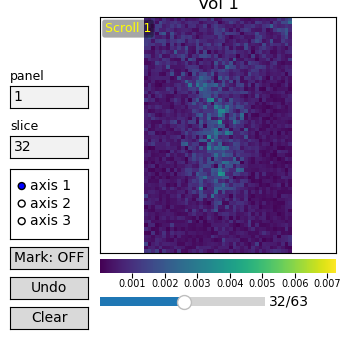

(<Figure size 480x449.333 with 9 Axes>,
 array([[<Axes: title={'center': 'Vol 1'}>]], dtype=object),
 {'layout_all': <function tools.JupyterPlotManager.volume_grid_viewer.<locals>.layout_all()>,
  'selected_panel': [0],
  'axis_per_panel': [0],
  'sliders': {0: <matplotlib.widgets.Slider at 0x7fce3c5e3160>},
  'images': {0: <matplotlib.image.AxesImage at 0x7fce541dffd0>},
  'markers': [],
  'marking_enabled': [False],
  'click_cid': 38,
  'key_cid': 39,
  'marker_counts': {},
  'slider_tick_lines': {}})

In [78]:
from tools import JupyterPlotManager
%matplotlib ipympl

JupyterPlotManager.volume_grid_viewer(vols=[da.abs(load_data[500,:,:,:])], rows=1, cols=1, cmap="viridis")

In [88]:
# Estimate the SNR
noise_roi = load_data[:, :15, :15, :15]

noise_power = np.mean(np.abs(noise_roi)**2)      # to get scalar
signal_power = np.mean(np.abs(load_data)**2, axis=0)  # volume is (64,64,40)

snr = signal_power / noise_power
#snr.compute()
snr_mean = np.mean(snr)
snr_mean.compute()

71.02173

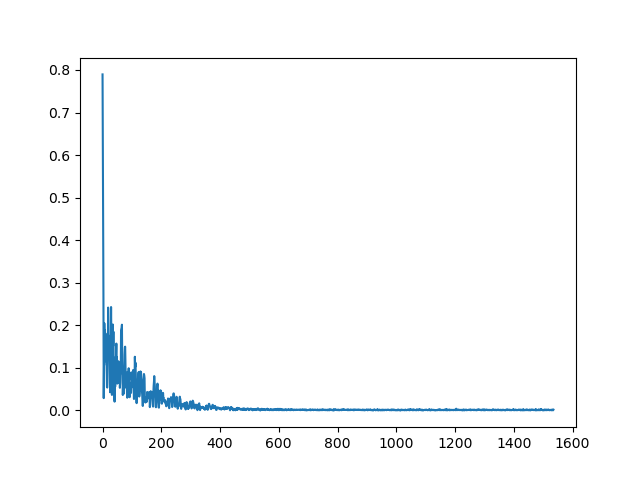

In [73]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure()
plt.plot(np.abs(load_data[:, 35,35,20]))
plt.show()

[ 76  ][ warning ] >> No reference frequency is specified. Choosing: 297223042 Hz.                                         
[ 77  ][ warning ] >> No ppm center is specified. Choosing: 4.7 ppm.                                                       


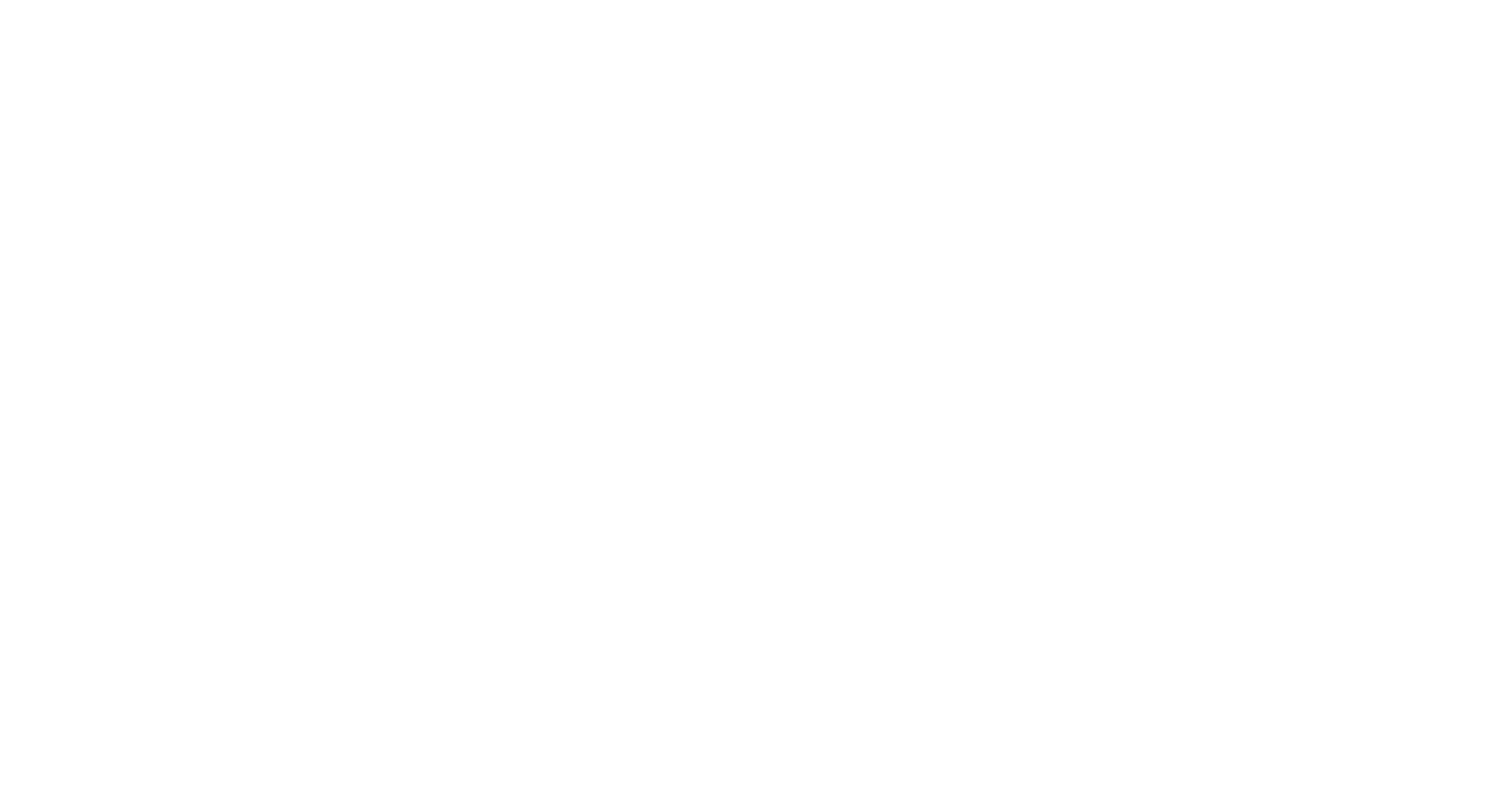

In [74]:
from spectral_spatial_simulation import FID


fid_one_signal = FID(signal=np.array(load_data[:, 35,35,20]), time=loaded_fid.time, name=f"FID at 35,35,20")
fid_one_signal.plot()

# Zarr to mat

In [1]:
import os
from os import listdir
import zarr
import numpy as np
from scipy.io import savemat
import dask.array as da
import file
import numpy as np

In [2]:
config_file_name = "paths_09012026.json"
configurator = file.Configurator(path_folder="../config/",
                                 file_name=config_file_name)
configurator.load()

In [3]:
load_data = da.from_zarr(os.path.join(configurator.data["checkpoints"], "zarr","checkpoint_out_test_09022026_withB0inHZ"))
load_data

dask.array<from-zarr, shape=(1536, 64, 64, 40), dtype=complex64, chunksize=(90, 64, 64, 40), chunktype=numpy.ndarray>

In [4]:
load_data_np = np.asarray(load_data)

In [5]:
savemat(os.path.join(configurator.data["checkpoints"], "mat","checkpoint_out_test_09022026_withB0inHZ.mat"), {"checkpoint_out_test_09022026_withB0inHZ": load_data_np}, do_compression=False)

# Add header information to mat file

In [75]:
import numpy as np
from scipy.io import savemat

load_data = da.from_zarr(os.path.join(configurator.data["checkpoints"], "zarr","checkpoint_out_test_09022026_withB0inHZ"))
load_data

load_data_transposed = np.transpose(load_data, (3, 0, 1, 2))

dwelltime_ns = 0.0003*10**9     # sec to nanoseconds (!)
fov_partition = 137.6  #(but not downsampled values!)
fov_phase = 220.0      #(but not downsampled values!)        
fov_read = 192.5       #(but not downsampled values!)
larmor_freq = 2.97224249751e8 # Hz
slice_normal = (0, 0, 1)
TR_us = TR.magnitude*10**6   # sec to microseconds
TEs_us = TE.magnitude*10**6  # sec to microseconds

csi = {
    "RecoPar": {
        "Dwelltimes": float(dwelltime_ns),
        "FoV_Partion": float(fov_partition),
        "FoV_Phase": float(fov_phase),
        "FoV_Read": float(fov_read),
        "LarmorFreq": float(larmor_freq),
        "SliceNormalVector_x": int(0),
        "SliceNormalVector_y": int(0),
        "SliceNormalVector_z": int(1),
        "TR": float(TR_us),
        "TEs": float(TEs_us),  # vector
    },
    "Data": np.asarray(load_data_transposed)
}

#savemat("csi.mat", {"csi": csi}, do_compression=True)

In [77]:
savemat(os.path.join(configurator.data["checkpoints"], "mat","checkpoint_out_test_23022026_with_header.mat"), {"csi": csi}, do_compression=False)

In [51]:
loaded_fid.time[1535]

0.4605

# compare with and without B0

In [6]:
from spectral_spatial_simulation import FID

In [1]:
import dask.array as da
import os
load_data_with_BO = da.from_zarr(os.path.join(configurator.data["checkpoints"], "zarr","checkpoint_out_test_09022026_withB0"))
load_data_with_BOHz = da.from_zarr(os.path.join(configurator.data["checkpoints"], "zarr","checkpoint_out_test_09022026_withB0inHZ"))
load_data_without_B0 = da.from_zarr(os.path.join(configurator.data["checkpoints"], "zarr","checkpoint_out_test_09022026_withoutB0"))

In [ ]:
load_data_with_BO_numpy = np.array(load_data_with_BO)

In [ ]:
load_data_with_BOHz_numpy = np.array(load_data_with_BOHz)

In [ ]:
load_data_without_B0_numpy = np.array(load_data_without_B0)

In [ ]:
load_data_with_BO_numpy[:,32,32,20]

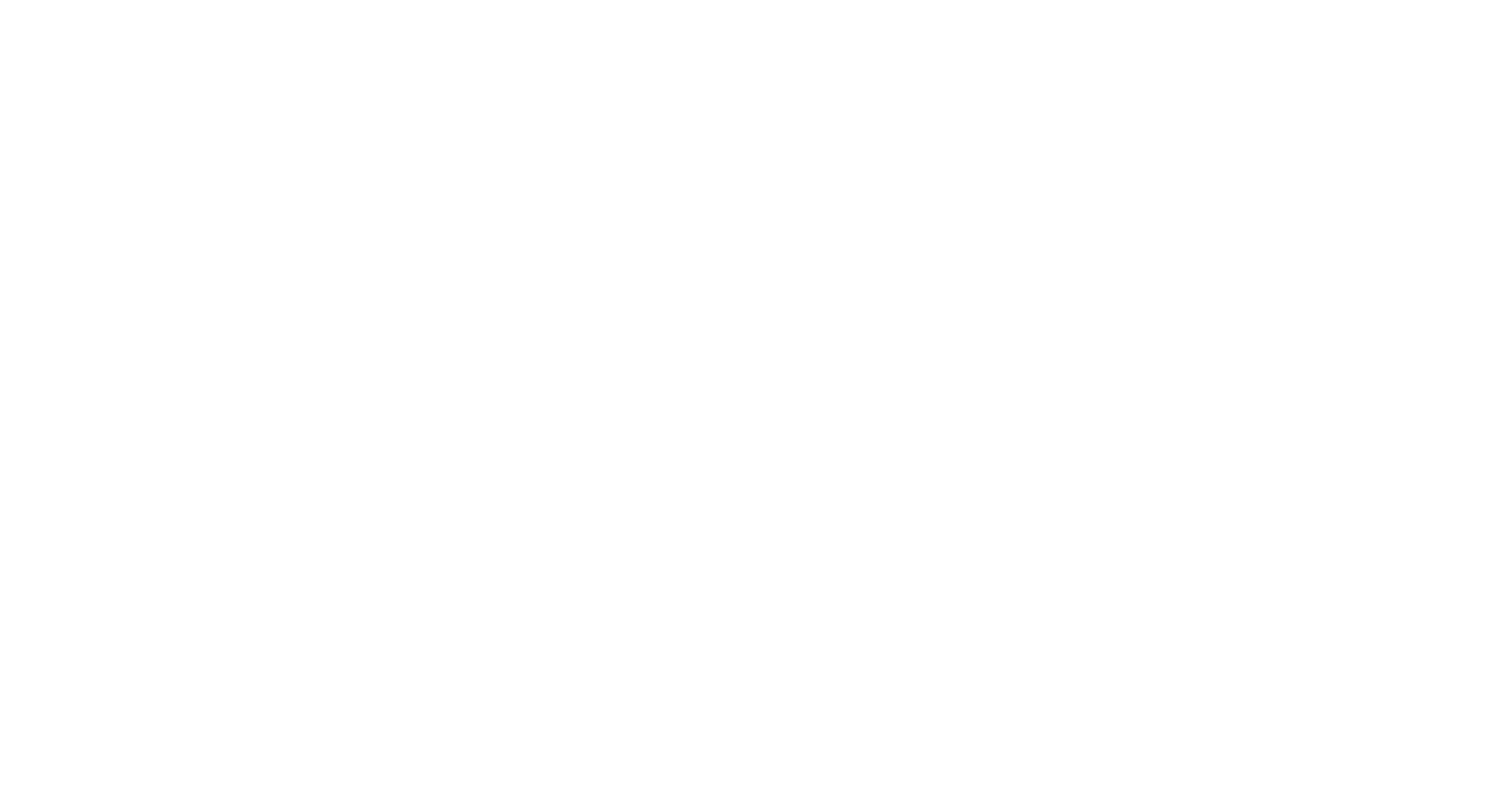

In [31]:
fid_with_B0 = FID(signal=load_data_with_BO_numpy[:,32,44,18], time=loaded_fid.time, name=["with B0"])
fid_with_B0Hz = FID(signal=load_data_with_BOHz_numpy[:,32,44,18], time=loaded_fid.time, name=["with B0 (in Hz)"])
fid_without_B0 = FID(signal=load_data_without_B0_numpy[:,32,44,18], time=loaded_fid.time, name=["without B0"])
fid_both = fid_with_B0 + fid_without_B0 + fid_with_B0Hz
fid_both.plot(plot_offset=0)

In [21]:
import h5py
import numpy as np

In [40]:
noise_correlation_path = configurator.data["maps"]["noise_correlation"]["path"]
with h5py.File(noise_correlation_path, "r") as f:
    #print(list(f.keys()))          # see top-level variable names
    noise_correlation = np.asarray(f["NoiseCorrMatStruct"]["Data"])
    noise_correlation_complex = noise_correlation["real"] + 1j * noise_correlation["imag"]
    #A = np.array(f["A"])           # read dataset into NumPy array

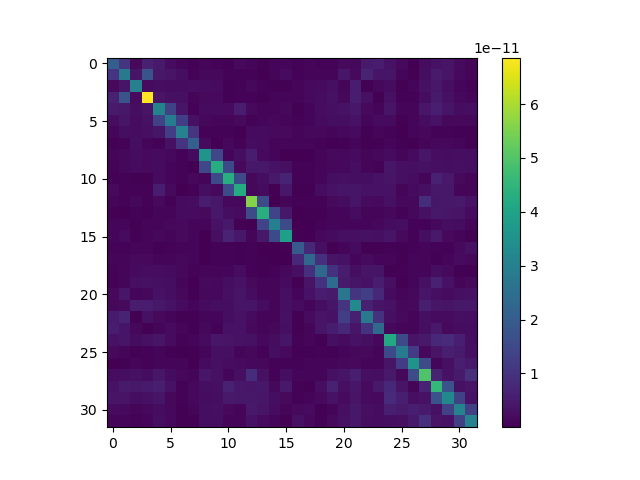

In [56]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(np.abs(noise_correlation_complex))
plt.colorbar()
plt.show()

In [44]:
np.sum(np.abs(noise_correlation_complex))

3.7094119e-09

In [52]:
from tools import ArrayTools

noise_correlation_complex_frobenius = noise_correlation_complex / np.linalg.norm(noise_correlation_complex)

print(ArrayTools.check_nan(noise_correlation_complex_frobenius))
ArrayTools.count_zeros(noise_correlation_complex_frobenius)

False
[  3  ][  info   ] >> Found number of zeros: 0                                                                             


0

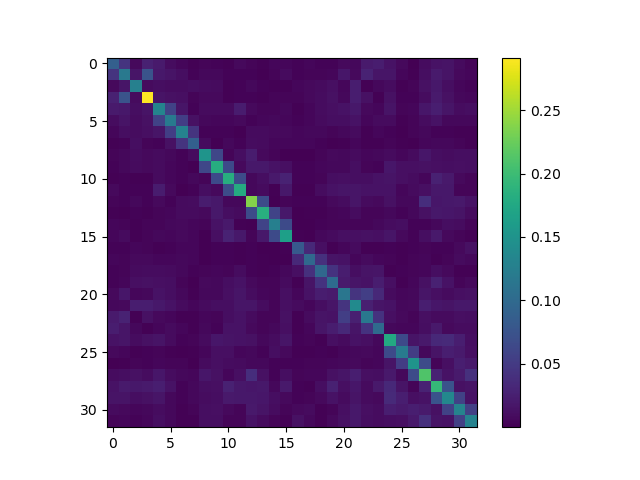

6.227301

In [73]:
plt.figure()
plt.imshow(np.abs(noise_correlation_complex_frobenius))
plt.colorbar()
plt.show()
np.abs(np.sum(noise_correlation_complex_frobenius))

In [82]:
noise_correlation_complex_32 = noise_correlation_complex * (noise_correlation_complex.shape[0] / np.trace(noise_correlation_complex))
#noise_correlation_complex_32 = noise_correlation_complex * (noise_correlation_complex.shape[0] / np.sum(noise_correlation_complex))

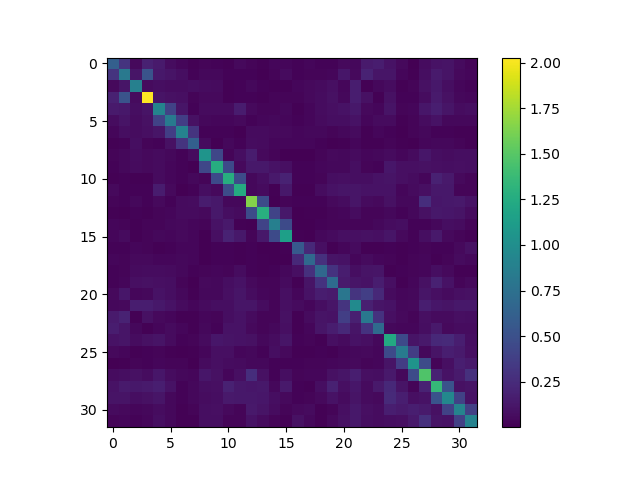

In [83]:
plt.figure()
plt.imshow(np.abs(noise_correlation_complex_32))
plt.colorbar()
plt.show()

In [ ]:
noise_correlation_complex_32

# Noise Correlation Matrix

$M_{noise} \cdot \biggl(\frac{n}{trace(M_{noise})}\biggr)$

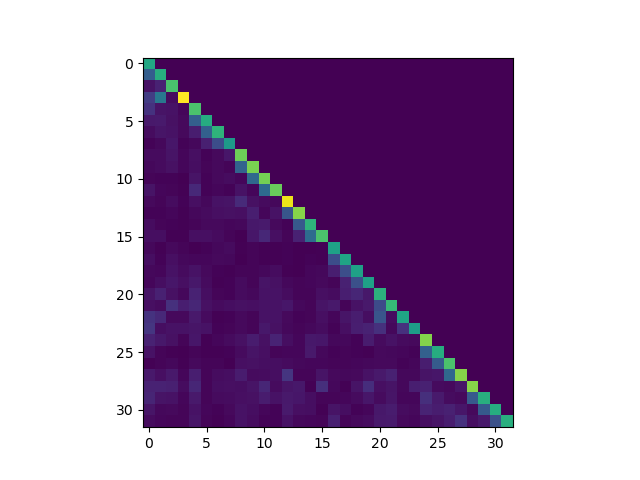

In [89]:
plt.figure()
plt.imshow(np.abs(np.linalg.cholesky(noise_correlation_complex_32)))
plt.show()

In [95]:
# Check if is Hermitian matrix
#   ==> thus values mirrowed around diagonal of a matrix
is_herm = np.allclose(noise_correlation_complex_32, noise_correlation_complex_32.conj().T, atol=1e-10)
print(is_herm)

True
True
